In [ ]:
!mkdir ../data
!wget -O ../data/fer2013.csv https://www.dropbox.com/s/zi48lkarsg4kbry/fer2013.csv\?dl\=1

In [ ]:
import pandas as pd
import numpy as np

DATA_PATH = "../data/fer2013.csv"

In [ ]:
def Read_Data(DATA_PATH):
  dataframe = pd.read_csv(DATA_PATH)
  data = np.array(list(map(str.split, dataframe.pixels)), np.float32)
  Mean = np.mean(data)
  train_data = dataframe.loc[dataframe['Usage'] == 'Training']
  test_data = dataframe.loc[dataframe['Usage'] != 'Training']
  train_data = np.array(list(map(str.split, train_data.pixels)), np.float32)
  test_data = np.array(list(map(str.split, test_data.pixels)), np.float32)
  train_data = train_data - Mean
  test_data = test_data - Mean
  data = data - Mean
  return train_data, test_data, data, dataframe

In [ ]:
def Find_Eigenvalue(data):
    covariance = np.cov(data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = np.sort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:,indices]
    return eigenvalues, eigenvectors

In [ ]:
def Emotions(dataframe):
  train_emotion = dataframe.loc[dataframe['Usage'] == 'Training']
  test_emotion = dataframe.loc[dataframe['Usage'] != 'Training']
  train_emotion = np.array(list(train_emotion.emotion))
  test_emotion = np.array(list(test_emotion.emotion))
  return train_emotion, test_emotion

In [ ]:
train, test, all_data, dataframe = Read_Data(DATA_PATH)

In [ ]:
train_emotion, test_emotion = Emotions(dataframe)

A:

In [ ]:
eigenvalues, eigenvectors = Find_Eigenvalue(all_data)
print(eigenvalues)

[2.66512420e+06 9.03136454e+05 8.68414944e+05 ... 4.29082479e+00
 4.17553368e+00 3.85456269e+00]


B:

In [ ]:
print(eigenvalues[:4])
print(eigenvectors[:,:4])

[2665124.19518341  903136.45445253  868414.94364041  507231.37879122]
[[-0.02427714  0.03270253  0.00333084  0.01637742]
 [-0.02406147  0.03383058  0.00387249  0.02034239]
 [-0.02399324  0.03437297  0.00460718  0.02400246]
 ...
 [-0.02333263  0.01116316 -0.0280134  -0.03070988]
 [-0.02339523  0.01205157 -0.02749968 -0.02989842]
 [-0.02336868  0.01238001 -0.02696041 -0.02890207]]


C:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
norm_train = np.linalg.norm(train)
norm_test = np.linalg.norm(test)
train = train / norm_train
test = test / norm_test

In [72]:
def KNN(train, test, train_emotion, test_emotion, N, type):
  classifier = KNeighborsClassifier(n_neighbors = N)
  classifier.fit(train, train_emotion)
  emotion_pred = classifier.predict(test)
  print("N ={} and data is {}".format(N, type))
  print("confusion matrix: ", confusion_matrix(test_emotion, emotion_pred))
  print("accuracy: ", accuracy_score(test_emotion, emotion_pred))

In [74]:
def Reduce(data, eigenvectors, dataframe, i):
  data = np.dot(eigenvectors[:,:i].transpose(), (data - np.mean(data)).transpose()).transpose()
  data = pd.DataFrame(data)
  train_data = data.loc[dataframe['Usage'] == 'Training']
  test_data = data.loc[dataframe['Usage'] != 'Training']
  return train_data, test_data

In [ ]:
train_reduced, test_reduced = Reduce(all_data, eigenvectors, dataframe, 4)

In [73]:
for i in range(1, 3):
  KNN(train, test, train_emotion, test_emotion, i, "initial")
for i in range(1, 3):
  KNN(train_reduced, test_reduced, train_emotion, test_emotion, i, "reduced")

N =1 and data is initial
confusion matrix:  [[329  13 111 149 135  58 163]
 [ 12  62   5  10   6   4  12]
 [122   7 389 137 127  96 146]
 [204  23 142 708 244 111 342]
 [180  17 135 221 379  64 251]
 [ 56   3  67  85  37 510  73]
 [141   9 105 248 206  81 443]]
accuracy:  0.3928670938980217
N =2 and data is initial
confusion matrix:  [[413  23 145 181 109  45  42]
 [ 21  63   9   7   4   3   4]
 [205  19 419 164 103  61  53]
 [393  36 232 768 184  78  83]
 [324  31 217 299 263  52  61]
 [133   8 125 142  51 349  23]
 [246  22 180 316 212  75 182]]
accuracy:  0.34229590415157424
N =1 and data is reduced
confusion matrix:  [[239   5 126 214 155  73 146]
 [ 12  46  12  16  10   5  10]
 [106  13 303 205 143 107 147]
 [215  28 210 557 272 164 328]
 [171  10 159 320 325  88 174]
 [ 71   8  77 129  76 390  80]
 [166   8 124 305 202 118 310]]
accuracy:  0.30231262190025077
N =2 and data is reduced
confusion matrix:  [[354  20 187 215 112  38  32]
 [ 21  46  17  14   7   5   1]
 [215  20 372 21

as we can see by using initial data we have better accuracy but with reduced data, the accuracy will be reduced too.

D:

In [75]:
def KNN_(train, test, train_emotion, test_emotion, N):
  classifier = KNeighborsClassifier(n_neighbors = N)
  classifier.fit(train, train_emotion)
  emotion_pred = classifier.predict(test)
  return accuracy_score(test_emotion, emotion_pred)

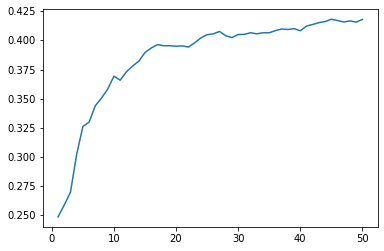

In [76]:
accuracy = []
for i in range(1, 51):
  train_reduced, test_reduced = Reduce(all_data, eigenvectors, dataframe, i)
  accuracy.append(KNN_(train_reduced, test_reduced, train_emotion, test_emotion, 1))
import matplotlib.pyplot as plt
x = np.arange(1, 51)
plt.plot(x, accuracy)
plt.show()

as we can see from the graph above, by increasing the number of components, the accuracy will be increased too. but we can see that it has a limited accuracy.